In [1]:
import logging
import random
from typing import List, NamedTuple, Callable, Dict, Any, Tuple, Union

import torch
import numpy
import pandas
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from torch import nn
from torch.utils.data import DataLoader, Dataset

In [2]:
logging.basicConfig(format="[%(asctime)s] %(levelname)s %(message)s", level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
seed = 1234

random.seed(seed)
numpy.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Config Template

In [4]:
class HW1Config(NamedTuple):
    batch_size: int
    device: str
    epochs: int
    model_saving_path: str
    optimizer: Callable
    optimizer_params: Dict[str, Any]

# Dataset

In [5]:
available_features = [
    "id",

    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "FL", "GA", "ID",
    "IL", "IN", "IA", "KS", "KY", "LA", "MD", "MA", "MI", "MN",
    "MS", "MO", "NE", "NV", "NJ", "NM", "NY", "NC", "OH", "OK",
    "OR", "PA", "RI", "SC", "TX", "UT", "VA", "WA", "WV", "WI",

    "cli",   "ili",   "hh_cmnty_cli",   "nohh_cmnty_cli",   "wearing_mask",   "travel_outside_state",   "work_outside_home",   "shop",   "restaurant",   "spent_time",
    "large_event",   "public_transit",   "anxious",   "depressed",   "felt_isolated",   "worried_become_ill",   "worried_finances",   "tested_positive",

    "cli.1", "ili.1", "hh_cmnty_cli.1", "nohh_cmnty_cli.1", "wearing_mask.1", "travel_outside_state.1", "work_outside_home.1", "shop.1", "restaurant.1", "spent_time.1",
    "large_event.1", "public_transit.1", "anxious.1", "depressed.1", "felt_isolated.1", "worried_become_ill.1", "worried_finances.1", "tested_positive.1",
    
    "cli.2", "ili.2", "hh_cmnty_cli.2", "nohh_cmnty_cli.2", "wearing_mask.2", "travel_outside_state.2", "work_outside_home.2", "shop.2", "restaurant.2", "spent_time.2",
    "large_event.2", "public_transit.2", "anxious.2", "depressed.2", "felt_isolated.2", "worried_become_ill.2", "worried_finances.2",
    
    "tested_positive.2"  # label, only available in training data
]

features = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "FL", "GA", "ID",
    "IL", "IN", "IA", "KS", "KY", "LA", "MD", "MA", "MI", "MN",
    "MS", "MO", "NE", "NV", "NJ", "NM", "NY", "NC", "OH", "OK",
    "OR", "PA", "RI", "SC", "TX", "UT", "VA", "WA", "WV", "WI",

#     "cli",   
#     "ili",   
#     "hh_cmnty_cli",   
#     "nohh_cmnty_cli",   
#     "wearing_mask",   
#     "travel_outside_state",   
#     "work_outside_home",   
#     "shop",   
#     "restaurant",   
#     "spent_time",
#     "large_event",   
#     "public_transit",  
#     "anxious",  
#     "depressed",  
#     "felt_isolated",
#     "worried_become_ill",
#     "worried_finances",
    "tested_positive",

#     "cli.1",
#     "ili.1",
#     "hh_cmnty_cli.1", 
#     "nohh_cmnty_cli.1",
#     "wearing_mask.1",
#     "travel_outside_state.1",
#     "work_outside_home.1",
#     "shop.1",
#     "restaurant.1", 
#     "spent_time.1",
#     "large_event.1", 
#     "public_transit.1", 
#     "anxious.1", 
#     "depressed.1", 
#     "felt_isolated.1",
#     "worried_become_ill.1", 
#     "worried_finances.1",
    "tested_positive.1",
    
#     "cli.2",
#     "ili.2", 
#     "hh_cmnty_cli.2",
#     "nohh_cmnty_cli.2", 
#     "wearing_mask.2",
#     "travel_outside_state.2",
#     "work_outside_home.2", 
#     "shop.2",
#     "restaurant.2", 
#     "spent_time.2",
#     "large_event.2",
#     "public_transit.2",
#     "anxious.2",
#     "depressed.2",
#     "felt_isolated.2",
#     "worried_become_ill.2",
#     "worried_finances.2",
]


class Covid19Dataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels
        
        logger.info("data: %s", self.data.shape)
        if self.labels is not None:
            logger.info("data: %s", self.labels.shape)
    
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, idx) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        if self.labels is not None:
            return self.data[idx], self.labels[idx]
        return self.data[idx]
    
    @property
    def dimension(self) -> int:
        return self.data.shape[1]
    
    
    @classmethod
    def create_dataset(cls, filepath: str, is_training: bool) -> 'Union[Covid19Dataset, Tuple[Covid19Dataset, Covid19Dataset]]':
        logger.info("Reading data from %s", filepath)
        original_data = pandas.read_csv(filepath)

        data = torch.FloatTensor(original_data[features].values)
        data[:, 40:] = (data[:, 40:] - data[:, 40:].mean(dim=0, keepdim=True)) / data[:, 40:].std(dim=0, keepdim=True)
        
        if not is_training:
            return cls(data=data)

        labels = torch.FloatTensor(original_data["tested_positive.2"].values)
        
        total_rows = len(data)
#         indexes1 = random.sample(range(total_rows), total_rows // 10)
#         indexes0 = [index for index in range(total_rows) if index not in indexes1]
        indexes1 = [i for i in range(total_rows) if i % 10 == 0]
        indexes0 = [i for i in range(total_rows) if i % 10 != 0]
        
        return cls(data=data[indexes0], labels=labels[indexes0]), cls(data=data[indexes1], labels=labels[indexes1])
        

    @classmethod
    def create_training_dataset(cls, filepath: str) -> 'Tuple[Covid19Dataset, Covid19Dataset]':
        return cls.create_dataset(filepath, is_training=True)
    
    @classmethod
    def create_testing_dataset(cls, filepath: str) -> 'Covid19Dataset':
        return cls.create_dataset(filepath, is_training=False)
    

# Model

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dimension):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dimension, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
        
        self.loss_function = nn.MSELoss(reduction="mean")
        
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.model(X).squeeze(1)
    
    def calculate_loss(self, y1: torch.Tensor, y2: torch.Tensor) -> torch.Tensor:
        return self.loss_function(y1, y2)

# Steps

In [7]:
class LossRecords(NamedTuple):
    training_loss: List[float] = []
    validation_loss: List[float] = []


def train_model(training_dataloader: DataLoader, validation_dataloader: DataLoader, model: NeuralNetwork, config: HW1Config) -> LossRecords:
    optimizer = config.optimizer(model.parameters(), **config.optimizer_params)
    minimal_validation_loss = 1e10
    loss_records = LossRecords()
    
    for epoch in range(config.epochs):
        model.train()
        
        for X, y in training_dataloader:
            X, y = X.to(config.device), y.to(config.device)
            
            optimizer.zero_grad()
            prediction = model(X)
            loss = model.calculate_loss(prediction, y)
            loss.backward()
            optimizer.step()
            
            loss_records.training_loss.append(loss.detach().cpu().item())
            
        model.eval()
        validation_loss = validate_model(validation_dataloader, model, config=config)
        loss_records.validation_loss.append(validation_loss)
        
        if validation_loss < minimal_validation_loss:
            minimal_validation_loss = validation_loss
            torch.save(model.state_dict(), config.model_saving_path)
            
        if epoch % (config.epochs // 10) == 0 or epoch == config.epochs - 1:
            logger.info(f">> Finish (epoch: {epoch + 1:4d}, min_loss: {minimal_validation_loss:.4f})")
            
    return loss_records
            
            
def validate_model(dataloader: DataLoader, model: NeuralNetwork, config: HW1Config):
    total_loss = 0
    
    for X, y in dataloader:
        X, y = X.to(config.device), y.to(config.device)
        with torch.no_grad():
            prediction = model(X)
            loss = model.calculate_loss(prediction, y)
            total_loss += loss.detach().cpu().item() * len(X)
            
    return total_loss / len(dataloader.dataset)


def test_model(dataloader: DataLoader, model: NeuralNetwork, config: HW1Config) -> torch.Tensor:
    predictions = []
    
    for X in dataloader:
        X = X.to(config.device)
        with torch.no_grad():
            predictions.append(model(X).detach().cpu())
    
    return torch.cat(predictions, dim=0)


def plot_learning_curve(loss_records: LossRecords) -> None:
    total_steps = len(loss_records.training_loss)
    x1 = range(total_steps)
    x2 = x1[::len(loss_records.training_loss) // len(loss_records.validation_loss)]
    
    figure(figsize=(6, 4))
    plt.plot(x1, loss_records.training_loss, c="tab:red", label="training")
    plt.plot(x2, loss_records.validation_loss, c="tab:cyan", label="validation")
    
    plt.ylim(0.0, 5.0)
    plt.xlabel("Training steps")
    plt.ylabel("Loss")
    plt.title("Learning curve")
    plt.legend()
    plt.show()

# Start!

In [8]:
config = HW1Config(
    batch_size=270,
    device="cuda" if torch.cuda.is_available() else "cpu",
    epochs=2000,
    model_saving_path="./data/model.zip",
    optimizer=torch.optim.SGD,
    optimizer_params={"lr": 0.001, "momentum": 0.9}
)

In [9]:
training_dataset, validation_dataset = Covid19Dataset.create_training_dataset("./data/covid.train.csv")
testing_dataset = Covid19Dataset.create_testing_dataset("./data/covid.test.csv")

training_dataloader = DataLoader(training_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=False)
validation_dataloader = DataLoader(validation_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
testing_dataloader = DataLoader(testing_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)

[2021-07-11 00:10:02,983] INFO Reading data from ./data/covid.train.csv
[2021-07-11 00:10:03,014] INFO data: torch.Size([2646, 42])
[2021-07-11 00:10:03,015] INFO data: torch.Size([2646])
[2021-07-11 00:10:03,015] INFO data: torch.Size([54, 42])
[2021-07-11 00:10:03,016] INFO data: torch.Size([54])
[2021-07-11 00:10:03,016] INFO Reading data from ./data/covid.test.csv
[2021-07-11 00:10:03,027] INFO data: torch.Size([893, 42])


In [10]:
model = NeuralNetwork(training_dataloader.dataset.dimension).to(config.device)
model

NeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=42, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (loss_function): MSELoss()
)

In [11]:
loss_records = train_model(training_dataloader, validation_dataloader, model, config=config)

[2021-07-11 00:10:04,913] INFO >> Finish (epoch:    1, min_loss: 257.3293)
[2021-07-11 00:10:08,654] INFO >> Finish (epoch:  201, min_loss: 0.8636)
[2021-07-11 00:10:12,291] INFO >> Finish (epoch:  401, min_loss: 0.8636)
[2021-07-11 00:10:15,942] INFO >> Finish (epoch:  601, min_loss: 0.8636)
[2021-07-11 00:10:19,589] INFO >> Finish (epoch:  801, min_loss: 0.8636)
[2021-07-11 00:10:23,246] INFO >> Finish (epoch: 1001, min_loss: 0.8636)
[2021-07-11 00:10:26,943] INFO >> Finish (epoch: 1201, min_loss: 0.8636)
[2021-07-11 00:10:30,608] INFO >> Finish (epoch: 1401, min_loss: 0.8636)
[2021-07-11 00:10:34,275] INFO >> Finish (epoch: 1601, min_loss: 0.8636)
[2021-07-11 00:10:38,015] INFO >> Finish (epoch: 1801, min_loss: 0.8636)
[2021-07-11 00:10:41,683] INFO >> Finish (epoch: 2000, min_loss: 0.8636)


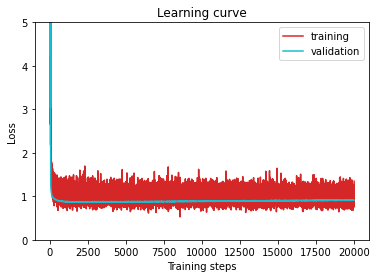

In [12]:
plot_learning_curve(loss_records)

In [13]:
del model

model_state = torch.load(config.model_saving_path, map_location="cpu")
model = NeuralNetwork(training_dataloader.dataset.dimension).to(config.device)
model.load_state_dict(model_state)

model.eval()
predictions = test_model(testing_dataloader, model, config=config)

In [14]:
pandas.DataFrame(predictions.numpy()).to_csv("./data/answer.csv", index_label="id", header=["tested_positive"])